198
(784,)
(23,)


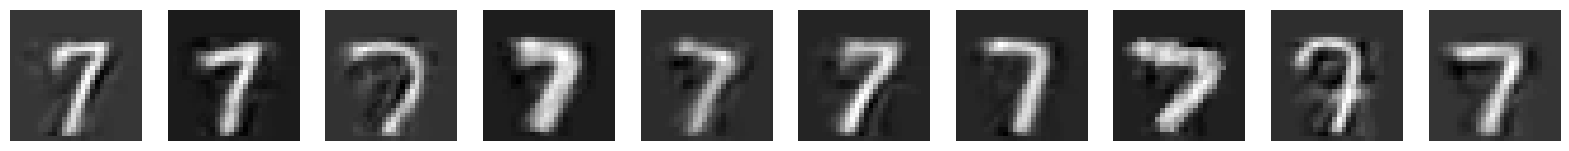

In [75]:
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST data loading
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: torch.flatten(x))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)

# Load a batch of images and their corresponding labels
images_labels = next(iter(train_loader))
# 筛选出label为1的
images = images_labels[0][images_labels[1] == 7]
# images = images_labels[0][:]
print(len(images))

images = images.numpy()


# Dimensionality reduction with PCA
pca = PCA(n_components=0.8, whiten=True)
images_pca = pca.fit_transform(images)
print(images[0].shape)
print(images_pca[0].shape)

# Train GMM
gmm = GaussianMixture(n_components=100, covariance_type='full', random_state=0)
gmm.fit(images_pca)

# Sample new data and transform it back to original space
new_samples, _ = gmm.sample(10)
new_images = pca.inverse_transform(new_samples)
new_images = new_images.reshape((10, 28, 28))  # Reshape to original image dimensions

# Visualize the new images
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))
for ax, image in zip(axes, new_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()


tensor([9])
8682


GaussianMixture(n_components=10, random_state=0)

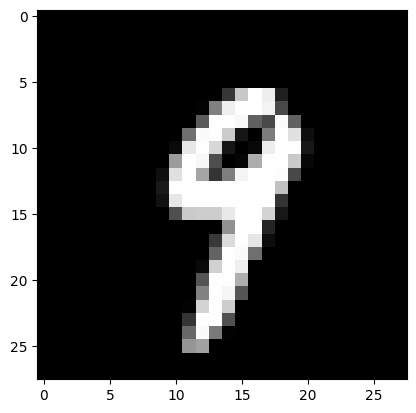

In [99]:
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import torch

# 加载MNIST数据集
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./dataset/GMM', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)

a=next(iter(loader))
print(a[1])
image=a[0].squeeze()
plt.imshow(image, cmap='gray')
# 提取灰度值较高的像素坐标

coords = []
image = image.numpy()

# 标准化灰度值到[0, 1]
image = image / image.max()
# 计算每个像素的出现次数
counts = (image * 100).astype(int)
y, x = np.where(image >= 0)
for i, j in zip(y, x):
    # 根据灰度值重复坐标
    coords.extend([(j, i)] * counts[i, j])

print(len(coords))
# 限制坐标数量，以便于处理
coords = np.array(coords)

# 使用GMM拟合坐标
gmm = GaussianMixture(n_components=10, random_state=0)
gmm.fit(coords)



# 生成新的样本点
# samples, _ = gmm.sample(1000)

# # 可视化
# plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6)
# plt.gca().invert_yaxis()
# plt.show()


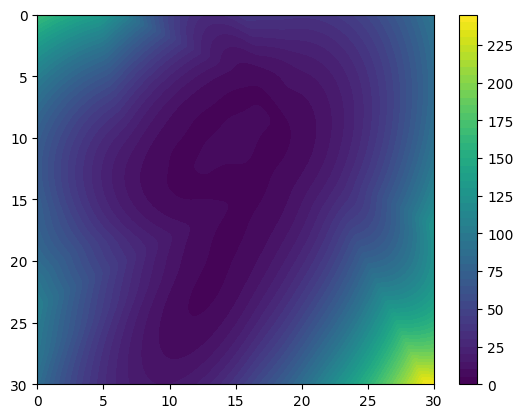

In [101]:


# 创建一个网格区域来计算GMM的概率密度
x = np.linspace(0, 30, 500)
y = np.linspace(0, 30, 500)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)  # 计算每个点的负对数似然值
Z = Z.reshape(X.shape)

# 使用contourf画出概率密度，概率密度越高的地方越亮
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

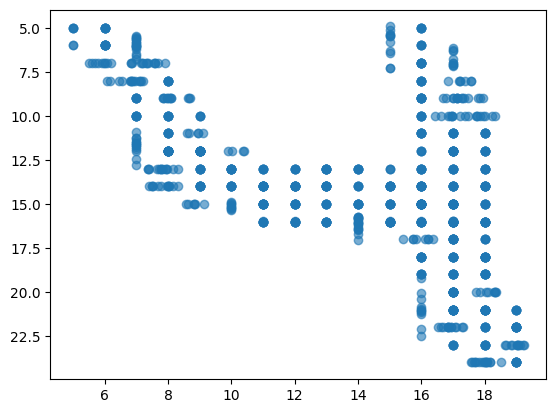

In [98]:
samples, _ = gmm.sample(1000)

# 可视化
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6)
plt.gca().invert_yaxis()
plt.show()